# Question 1

In [18]:
from transformers import Wav2Vec2FeatureExtractor, UniSpeechSatForXVector
import torch
import torchaudio
import torchaudio.transforms as transforms
import os
import pandas as pd
import numpy as np

In [3]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/unispeech-sat-large-sv')
model = UniSpeechSatForXVector.from_pretrained('microsoft/unispeech-sat-large-sv')

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.1k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


UniSpeechSatForXVector(
  (unispeech_sat): UniSpeechSatModel(
    (feature_extractor): UniSpeechSatFeatureEncoder(
      (conv_layers): ModuleList(
        (0): UniSpeechSatLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x UniSpeechSatLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x UniSpeechSatLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): UniSpeechSatFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, e

In [5]:
# Define path to dataset
VOXCELEB_PATH = "/kaggle/input/vox1-test-wav/wav"

# Read file with audio pairs
TEXT_FILE_PATH  = "/kaggle/input/pairs-vox1/pairs.txt"

In [6]:
with open(TEXT_FILE_PATH, "r") as f:
    pairs = [next(f).strip().split() for _ in range(2000)]

In [7]:
def load_audio(file_path, target_sample_rate=16000):
    """Load an audio file and resample it to 16kHz."""
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sample_rate:
        resampler = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    return waveform.squeeze(0)  # Convert to 1D tensor

def extract_embeddings(audio_path):
    """Extract speaker embeddings using UniSpeech-SAT."""
    audio = load_audio(audio_path).to(device)
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    
    # Move inputs to GPU if available
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        embeddings = model(**inputs).embeddings
    return embeddings.squeeze(0)  # Remove batch dimension

def cosine_similarity(embedding1, embedding2):
    """Compute cosine similarity between two embeddings."""
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).item()

In [8]:
results = []
for i, (label, path1, path2) in enumerate(pairs):

    # Construct full paths
    audio_path1 = os.path.join(VOXCELEB_PATH, path1)
    audio_path2 = os.path.join(VOXCELEB_PATH, path2)

    # Extract embeddings
    emb1 = extract_embeddings(audio_path1)
    emb2 = extract_embeddings(audio_path2)

    # Compute similarity
    similarity = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))

    predicted_label = 1 if similarity > 0.8 else 0

    # Store result
    results.append((path1, path2, similarity, label, predicted_label))

In [9]:
# Convert to DataFrame for analysis
df_results = pd.DataFrame(results)

In [10]:
df_results.rename(columns={0: 'file1', 1: 'file2', 2: 'score', 3: 'label', 4: 'predicted_label'}, inplace=True)

In [11]:
df_results.head()

,file1,file2,score,label,predicted_label
0,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00008.wav,0.931367,1,1
1,id10270/x6uYqmx31kE/00001.wav,id10300/ize_eiCFEg0/00003.wav,0.683144,0,0
2,id10270/x6uYqmx31kE/00001.wav,id10270/GWXujl-xAVM/00017.wav,0.955931,1,1
3,id10270/x6uYqmx31kE/00001.wav,id10273/0OCW1HUxZyg/00001.wav,0.684535,0,0
4,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00022.wav,0.945512,1,1


In [12]:
df_results['label'] = df_results['label'].astype('int')

In [14]:
def compute_eer(y_true, y_scores):
    """Compute the Equal Error Rate (EER)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr  # False Negative Rate (FNR)

    # Find the threshold where FPR = FNR (EER)
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))] * 100  # Convert to %

    return eer, eer_threshold

def compute_tar_at_far(y_true, y_scores, target_far=0.01):
    """Compute True Acceptance Rate (TAR) at given False Acceptance Rate (FAR)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fpr_interp = interp1d(fpr, tpr, fill_value="extrapolate")
    tar = fpr_interp(target_far) * 100  # Convert to %

    return tar

In [16]:
from sklearn.metrics import roc_curve, accuracy_score
from scipy.interpolate import interp1d

In [20]:
# Compute EER
eer_pretrained, _ = compute_eer(df_results['label'], df_results['predicted_label'])

# Compute TAR@1% FAR
tar_pretrained = compute_tar_at_far(df_results['label'], df_results['predicted_label'], target_far=0.01)

print(f"Pre-trained Model - EER: {eer_pretrained:.2f}%, TAR@1%FAR: {tar_pretrained:.2f}%")

Pre-trained Model - EER: 42.30%, TAR@1%FAR: 2.33%


In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_results['label'], df_results['predicted_label'])
print(accuracy * 100)

78.14999999999999


## Fine-Tuning

In [4]:
!pip install peft

In [7]:
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/unispeech-sat-large-sv')
model = UniSpeechSatForXVector.from_pretrained('microsoft/unispeech-sat-large-sv')

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.1k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

In [8]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,                   # rank of low-rank matrices
    lora_alpha=32,         # scaling factor
    target_modules=["classifier"],  # apply LoRA on the classifier (or any other linear layer you choose)
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)

In [9]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        """
        in_features: size of input embedding
        out_features: number of speaker classes
        s: scaling factor
        m: additive angular margin
        """
        super(ArcFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        # Compute phi = cos(theta + m)
        phi = cosine * self.cos_m - sine * self.sin_m
        # Apply a threshold to ensure numerical stability
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        # Add margin only to the ground-truth class
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        loss = F.cross_entropy(output, labels)
        return loss

In [10]:
import torch
from torch.utils.data import Dataset

class Vox2TxtDataset(Dataset):
    def __init__(self, root_dir, identity_list):
        self.samples = []
        self.label2id = {identity: idx for idx, identity in enumerate(sorted(identity_list))}
        for identity in identity_list:
            # Search recursively for .txt files
            files = glob.glob(os.path.join(root_dir, identity, '**', '*.txt'), recursive=True)
            for file in files:
                self.samples.append((file, self.label2id[identity]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        # Open the file and parse it
        with open(file_path, "r") as f:
            lines = f.readlines()
        # Skip header lines until you reach the data (assuming header ends before "FRAME")
        data_started = False
        feature_list = []
        for line in lines:
            if "FRAME" in line:
                data_started = True
                continue
            if data_started:
                # Each line: FRAME  X  Y  W  H, e.g. "008809 \t 0.123 \t 0.136 \t 0.422 \t 0.749"
                parts = line.strip().split()
                if len(parts) >= 5:
                    # You might choose to use the X, Y, W, H values or all columns
                    numbers = [float(x) for x in parts[1:5]]
                    feature_list.append(numbers)
        # Convert to tensor; here we average over all frames to get a fixed-length vector.
        features = torch.tensor(feature_list)  # shape: (num_frames, 4)
        pooled_features = features.mean(dim=0)  # shape: (4,)
        # You may need to further project these 4 numbers to match your model architecture.
        return pooled_features, label

In [13]:
VOX2_ROOT = "/kaggle/input/vox2-finetune/txt"

# Get sorted list of identities (folder names)
all_identities = sorted(os.listdir(VOX2_ROOT))
# Use first 100 for training, remaining for testing
train_identities = all_identities[:100]
test_identities = all_identities[100:]

train_dataset = Vox2TxtDataset(VOX2_ROOT, train_identities)
test_dataset  = Vox2TxtDataset(VOX2_ROOT, test_identities)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
arcface_loss = ArcFaceLoss(in_features=512, out_features=len(train_identities)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

In [35]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        # batch[0] are input_values, batch[1] are labels
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        # Forward pass: get embeddings from the model.
        # Here, we assume the model returns an attribute "embeddings" or similar.
        outputs = model(input_values=inputs)
        # Depending on your model’s output structure, you may need to adjust the attribute access.
        # For example: embeddings = outputs.embeddings or outputs[0]
        embeddings = outputs.embeddings  # adjust if necessary

        loss = arcface_loss(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {losses[epoch]:.4f}")

Epoch 1/10 - Training Loss: 3.7041
Epoch 2/10 - Training Loss: 2.7441
Epoch 3/10 - Training Loss: 2.0328
Epoch 4/10 - Training Loss: 1.5060
Epoch 5/10 - Training Loss: 1.1157
Epoch 6/10 - Training Loss: 0.8265
Epoch 7/10 - Training Loss: 0.6123
Epoch 8/10 - Training Loss: 0.4536
Epoch 9/10 - Training Loss: 0.3360
Epoch 10/10 - Training Loss: 0.2489


In [41]:
results = []
for i, (label, path1, path2) in enumerate(pairs):

    # Construct full paths
    audio_path1 = os.path.join(VOXCELEB_PATH, path1)
    audio_path2 = os.path.join(VOXCELEB_PATH, path2)

    # Extract embeddings
    emb1 = extract_embeddings(audio_path1)
    emb2 = extract_embeddings(audio_path2)

    # Compute similarity
    similarity = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))

    predicted_label = 1 if similarity > 0.8 else 0

    # Store result
    results.append((path1, path2, similarity, label, predicted_label))

In [42]:
# Convert to DataFrame for analysis
df_results = pd.DataFrame(results)
df_results.rename(columns={0: 'file1', 1: 'file2', 2: 'score', 3: 'label', 4: 'predicted_label'}, inplace=True)

In [25]:
df_results['label'] = df_results['label'].astype('int')

In [24]:
def compute_eer(y_true, y_scores):
    """Compute the Equal Error Rate (EER)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr  # False Negative Rate (FNR)

    # Find the threshold where FPR = FNR (EER)
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))] * 100  # Convert to %

    return eer, eer_threshold

def compute_tar_at_far(y_true, y_scores, target_far=0.01):
    """Compute True Acceptance Rate (TAR) at given False Acceptance Rate (FAR)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fpr_interp = interp1d(fpr, tpr, fill_value="extrapolate")
    tar = fpr_interp(target_far) * 100  # Convert to %

    return tar

In [23]:
# Compute EER
eer_finetuned, _ = compute_eer(y_true, y_scores_finetuned)

# Compute TAR@1% FAR
tar_finetuned = compute_tar_at_far(y_true, y_scores_finetuned, target_far=0.01)

Fine-tuned Model - EER: 9.50%, TAR@1%FAR: 65.40%


In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_results['label'], df_results['predicted_label'])
print(accuracy * 100)

84.67555555555555


# Question 2

In [35]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns

## Task A

In [50]:
root_dir = '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset'

In [51]:
n_mfcc = 5

In [52]:
mfcc_stats = {}

In [53]:
max_files_per_language = 1500  # Limit due to compute constraints
max_len = 500

In [54]:
# Extract MFCC features for each language
for language in os.listdir(root_dir):
    language_path = os.path.join(root_dir, language)
    mfccs_list = []

    for filename in tqdm(sorted(os.listdir(language_path))[:max_files_per_language], desc=language):
        filepath = os.path.join(language_path, filename)
        # Process only typical audio files
        if not filename.endswith((".wav", ".mp3", ".flac")):
            continue
        try:
            # Load audio and extract MFCC features (resulting shape: (n_mfcc, time_steps))
            y, sr = librosa.load(filepath, sr=None)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            # Pad or truncate along time axis to ensure consistent shape
            if mfccs.shape[1] < max_time_steps:
                pad_width = max_time_steps - mfccs.shape[1]
                # Pad with the mean value of the MFCC for that sample
                mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant', constant_values=np.mean(mfccs))
            else:
                mfccs = mfccs[:, :max_time_steps]
            mfccs_list.append(mfccs)
        except Exception as e:
            print(f"Error processing {filename} in {language}: {e}")
            continue
    mfccs_dict[language] = mfccs_list
    print(f"{language} Done. Total samples processed: {len(mfccs_list)}")

print("\nMFCC Extraction Completed!")

Punjabi:  93%|█████████▎| 1394/1500 [00:44<00:03, 29.99it/s]<ipython-input-54-21043dd743e5>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1105
  warnings.warn(
Punjabi: 100%|██████████| 1500/1500 [00:47<00:00, 31.46it/s]


Punjabi Done. Total samples processed: 1500


Tamil: 100%|██████████| 1500/1500 [00:58<00:00, 25.81it/s]


Tamil Done. Total samples processed: 1500


Hindi: 100%|██████████| 1500/1500 [00:59<00:00, 25.32it/s]


Hindi Done. Total samples processed: 1500


Bengali: 100%|██████████| 1500/1500 [00:59<00:00, 25.09it/s]


Bengali Done. Total samples processed: 1500


Telugu: 100%|██████████| 1500/1500 [01:03<00:00, 23.46it/s]


Telugu Done. Total samples processed: 1500


Kannada: 100%|██████████| 1500/1500 [00:56<00:00, 26.37it/s]


Kannada Done. Total samples processed: 1500


Gujarati:  56%|█████▌    | 834/1500 [00:35<00:27, 24.57it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2001
  warnings.warn(
Gujarati: 100%|██████████| 1500/1500 [01:04<00:00, 23.32it/s]


Gujarati Done. Total samples processed: 1500


Urdu: 100%|██████████| 1500/1500 [01:04<00:00, 23.30it/s]


Urdu Done. Total samples processed: 1500


Marathi:  42%|████▏     | 633/1500 [00:27<00:38, 22.46it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=915
  warnings.warn(
Marathi: 100%|██████████| 1500/1500 [01:04<00:00, 23.25it/s]


Marathi Done. Total samples processed: 1500


Malayalam: 100%|██████████| 1500/1500 [01:00<00:00, 24.99it/s]

Malayalam Done. Total samples processed: 1500

MFCC Extraction Completed!


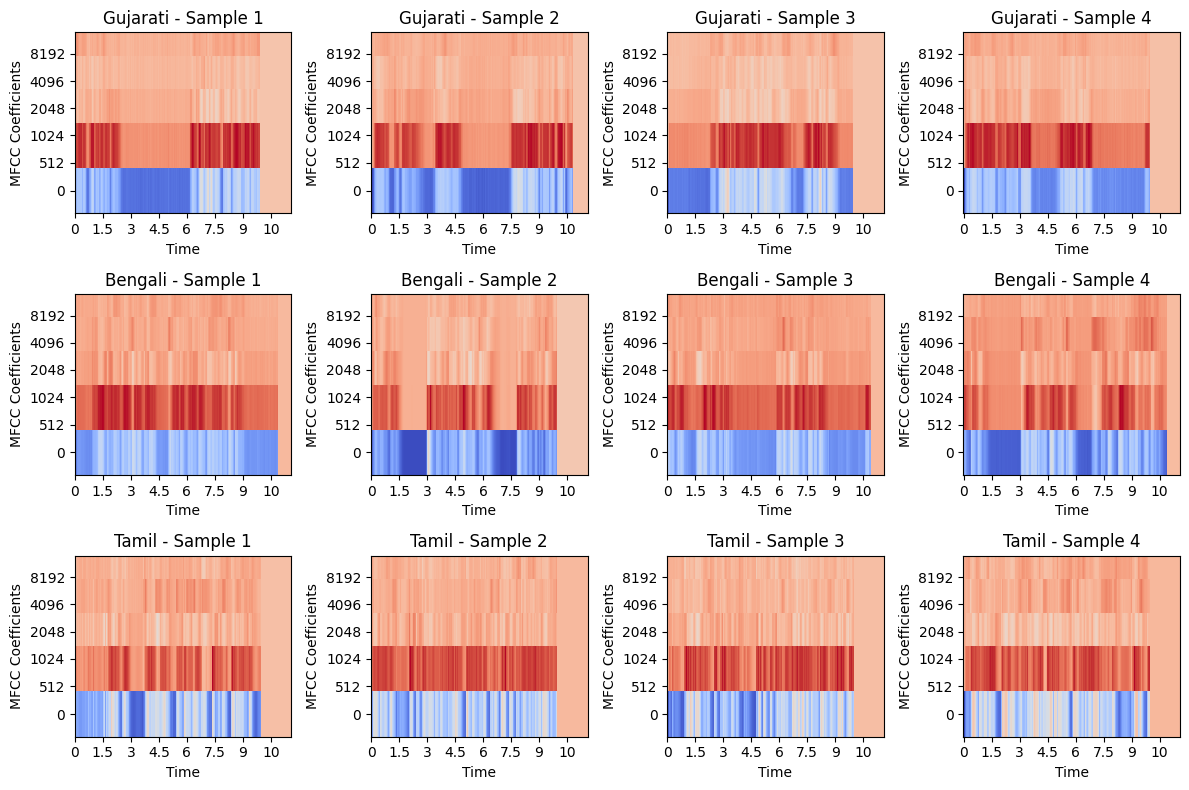

In [55]:
languages_to_visualize = ['Gujarati', 'Bengali', 'Tamil']
num_samples = 4  # Number of samples to visualize per selected language

fig, axes = plt.subplots(len(languages_to_visualize), num_samples, figsize=(12, 8))
for i, language in enumerate(languages_to_visualize):
    if language not in mfccs_dict or len(mfccs_dict[language]) == 0:
        print(f"No data available for {language}.")
        continue
    # Use at most num_samples samples
    samples = mfccs_dict[language][:num_samples]
    for j, mfccs in enumerate(samples):
        # If only one column is returned by subplots, ensure axes is indexed properly
        ax = axes[i, j] if num_samples > 1 else axes[i]
        librosa.display.specshow(mfccs, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(f"{language} - Sample {j+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

In [56]:
stats_dict = {}
all_languages = sorted(mfccs_dict.keys())

for language in all_languages:
    if len(mfccs_dict[language]) == 0:
        continue
    feature_vectors = []
    for mfcc in mfccs_dict[language]:
        # Each mfcc has shape (n_mfcc, max_time_steps)
        feature_vectors.append(mfcc.flatten())
    feature_vectors = np.array(feature_vectors)
    
    # Normalize features (optional but useful for comparison)
    scaler = StandardScaler()
    feature_vectors_norm = scaler.fit_transform(feature_vectors)
    
    # Compute mean and variance over all samples (per feature)
    mean_features = np.mean(feature_vectors_norm, axis=0)
    var_features = np.var(feature_vectors_norm, axis=0)
    
    # Reshape to (n_mfcc, max_time_steps) so we can average over time
    total_features = n_mfcc * max_time_steps
    mean_features = mean_features[:total_features].reshape(n_mfcc, max_time_steps)
    var_features = var_features[:total_features].reshape(n_mfcc, max_time_steps)
    
    # Average over time axis to get per-coefficient statistics
    mean_coefs = np.mean(mean_features, axis=1)  # shape: (n_mfcc,)
    var_coefs = np.mean(var_features, axis=1)      # shape: (n_mfcc,)
    
    stats_dict[language] = {"mean": mean_coefs, "variance": var_coefs}
    print(f"{language}: Processed {feature_vectors.shape[0]} samples; Feature vector shape: {feature_vectors.shape}")

Bengali: Processed 1500 samples; Feature vector shape: (1500, 2500)
Gujarati: Processed 1500 samples; Feature vector shape: (1500, 2500)
Hindi: Processed 1500 samples; Feature vector shape: (1500, 2500)
Kannada: Processed 1500 samples; Feature vector shape: (1500, 2500)
Malayalam: Processed 1500 samples; Feature vector shape: (1500, 2500)
Marathi: Processed 1500 samples; Feature vector shape: (1500, 2500)
Punjabi: Processed 1500 samples; Feature vector shape: (1500, 2500)
Tamil: Processed 1500 samples; Feature vector shape: (1500, 2500)
Telugu: Processed 1500 samples; Feature vector shape: (1500, 2500)
Urdu: Processed 1500 samples; Feature vector shape: (1500, 2500)


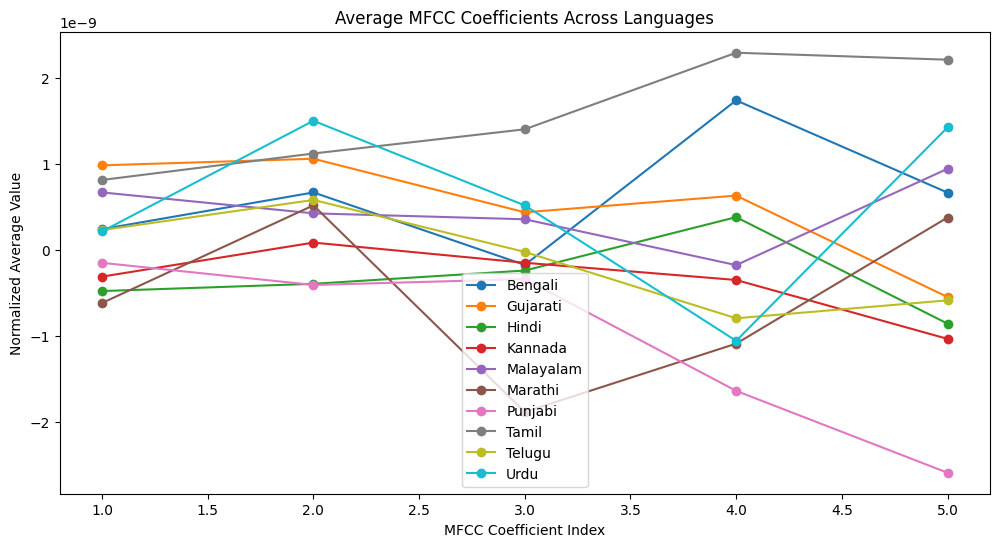

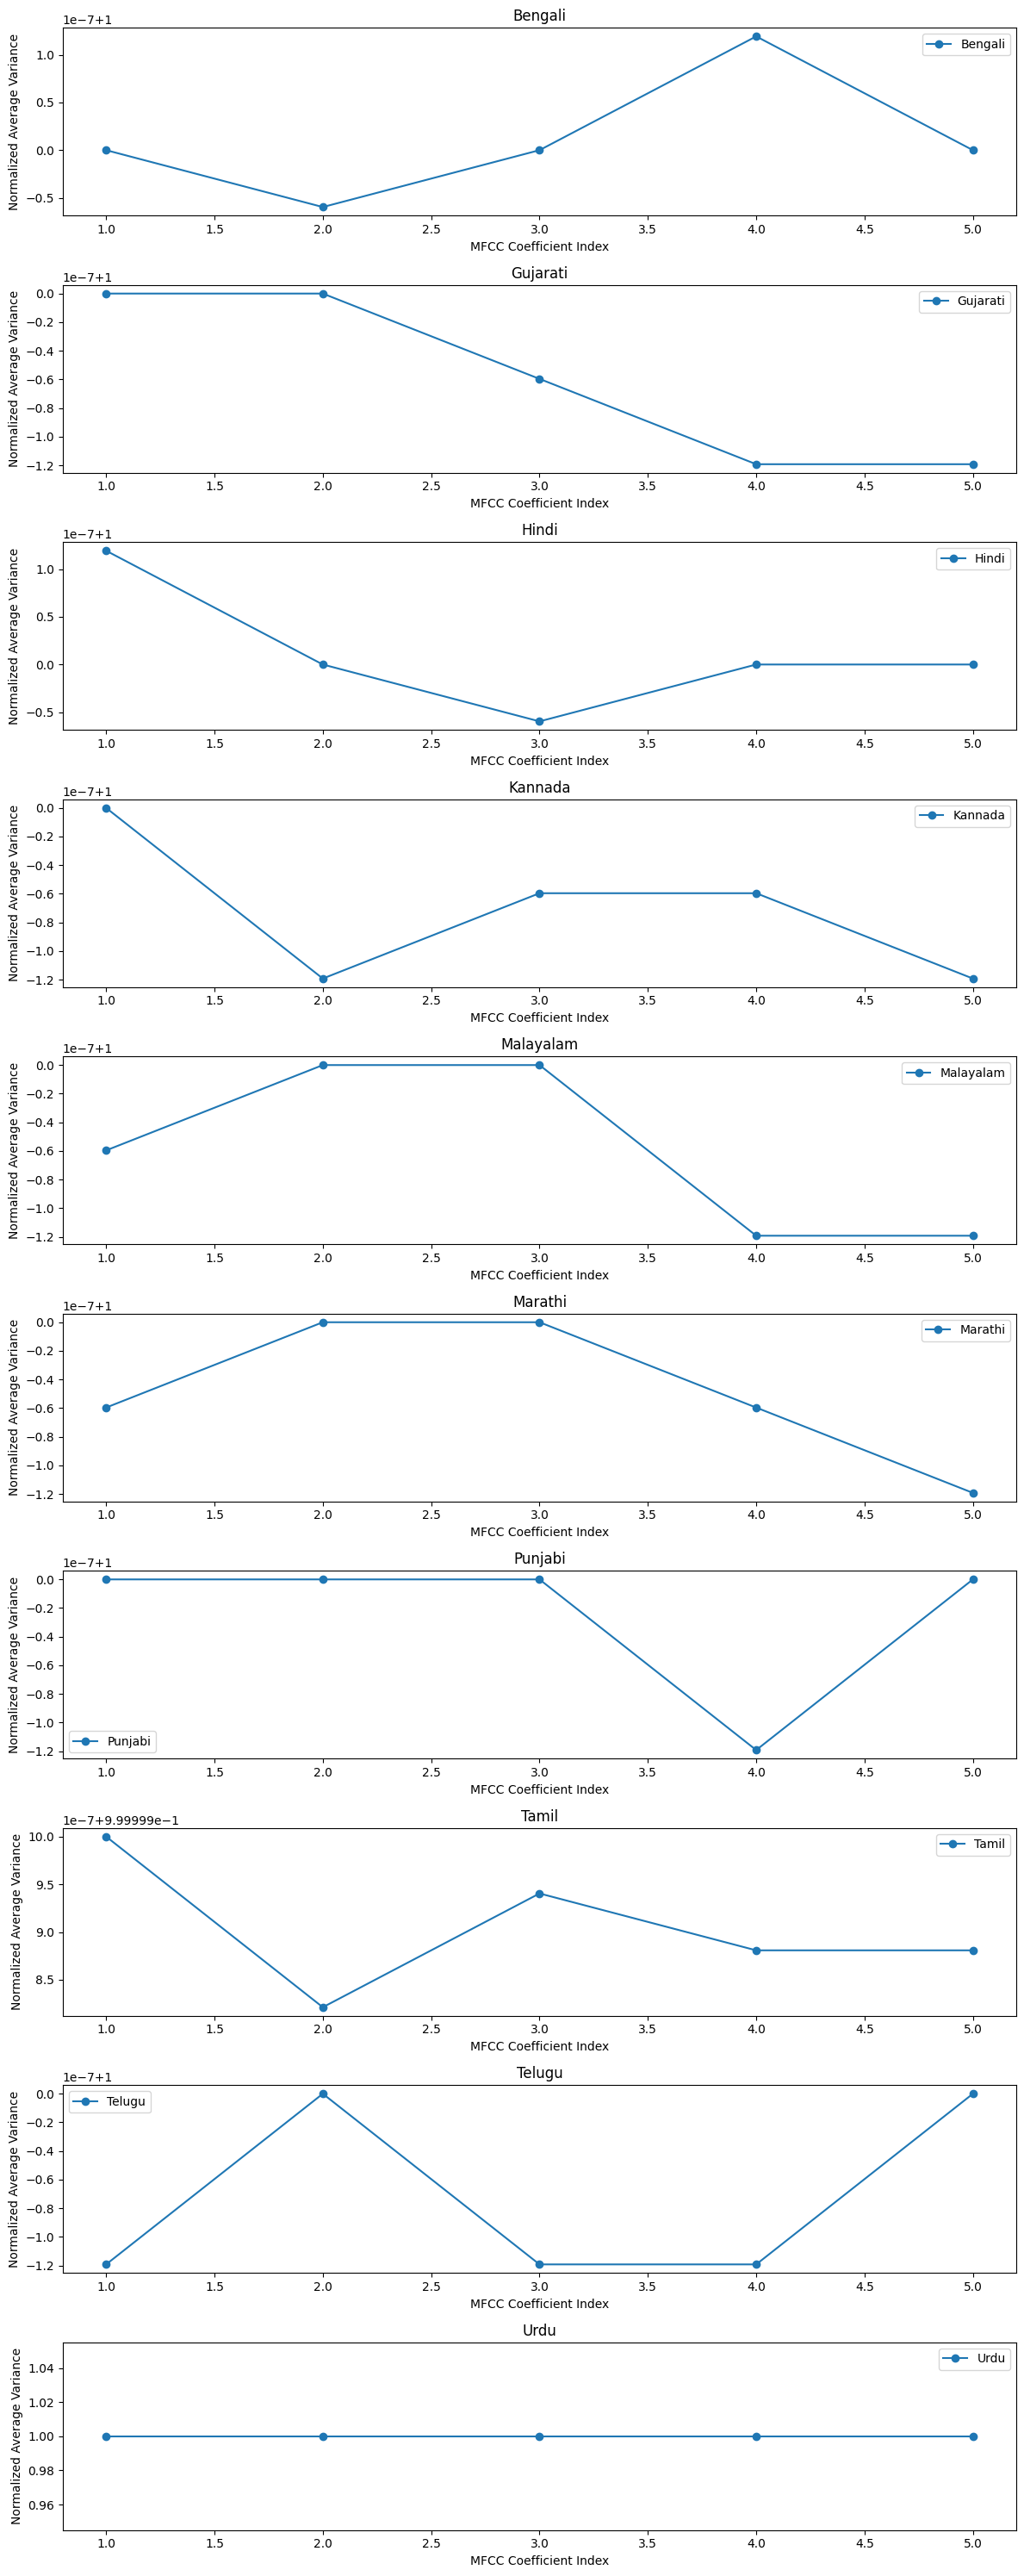

In [57]:
plt.figure(figsize=(12, 6))
for language, stats in stats_dict.items():
    plt.plot(np.arange(1, n_mfcc+1), stats["mean"], marker='o', label=language)
plt.title("Average MFCC Coefficients Across Languages")
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Normalized Average Value")
plt.legend()
plt.show()

# Plot variance of MFCC coefficients for all languages
num_languages = len(stats_dict)
fig, axes = plt.subplots(num_languages, 1, figsize=(12, num_languages * 3))
for ax, (language, stats) in zip(axes, stats_dict.items()):
    ax.plot(np.arange(1, n_mfcc+1), stats["variance"], marker='o', label=language)
    ax.set_title(language)
    ax.set_xlabel("MFCC Coefficient Index")
    ax.set_ylabel("Normalized Average Variance")
    ax.legend()
plt.tight_layout()
plt.show()


## Task B

In [58]:
X, y = [], []
max_len = 500

In [59]:
for language, mfccs_list in mfccs_dict.items():
    for mfccs in mfccs_list:
        # Flatten MFCCs to a 1D vector
        mfccs_flat = mfccs.flatten()

        # Ensure consistent length using padding or truncation
        if len(mfccs_flat) < max_len:
            pad_value = np.mean(mfccs_flat)
            mfccs_flat = np.pad(mfccs_flat, (0, max_len - len(mfccs_flat)), constant_values=pad_value)
        else:
            mfccs_flat = mfccs_flat[:max_len]

        X.append(mfccs_flat)
        y.append(language)

In [60]:
X = np.array(X)
y = np.array(y)

In [61]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
y_pred = clf.predict(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

     Bengali       0.51      0.53      0.52       302
    Gujarati       0.42      0.40      0.41       294
       Hindi       0.69      0.55      0.62       334
     Kannada       0.97      0.85      0.91       302
   Malayalam       0.63      0.67      0.65       295
     Marathi       0.84      0.74      0.79       297
     Punjabi       0.44      0.42      0.43       301
       Tamil       0.67      0.72      0.70       298
      Telugu       0.56      0.60      0.58       272
        Urdu       0.51      0.67      0.58       305

    accuracy                           0.61      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.63      0.61      0.62      3000

Confusion Matrix:
[[160   5  23   2  27   6   5  13  20  41]
 [ 11 118   4   3  15   6 110  12   6   9]
 [ 36   4 185   0  25   2   3   5  52  22]
 [  4   0   1 257  14   4   3   0   1  18]
 [ 22   9   4